In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import sqlalchemy
from sklearn import tree, ensemble, metrics
from patsy import dmatrices
%matplotlib inline
plt.style.use('ggplot')

In [2]:
con = sqlite3.connect('database.sqlite')

In [187]:
salarydf = pd.read_sql_query('SELECT * FROM Salaries',con)

In [188]:
salarydf.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,,567595.43,567595.43,2011,,San Francisco,
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245132,137811,,538909.28,538909.28,2011,,San Francisco,
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739,106088,16452.6,,335279.91,335279.91,2011,,San Francisco,
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916,56120.7,198307,,332343.61,332343.61,2011,,San Francisco,
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134402,9737,182235,,326373.19,326373.19,2011,,San Francisco,


# Lets take a look at the distribution of positions

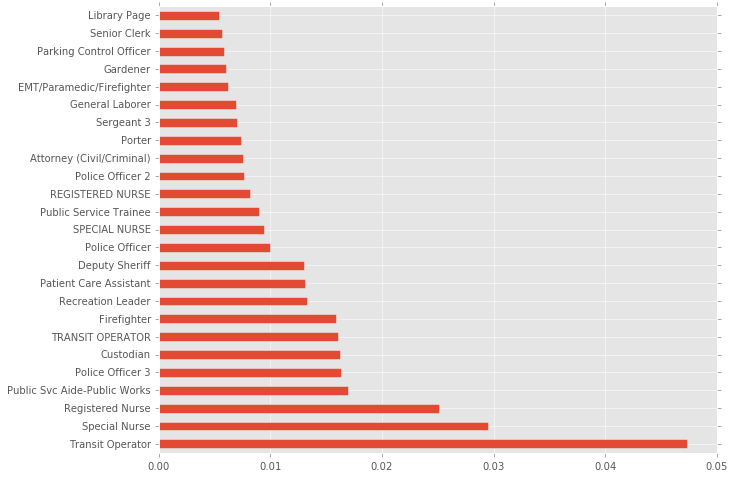

In [189]:
salarydf.JobTitle.value_counts(normalize=True).head(25).plot(kind='barh',figsize=(10,8))

## Let's fix the inconsistent cases of Job Titles

In [190]:
salarydf['JobTitleFormatted'] = salarydf.JobTitle.str.title()

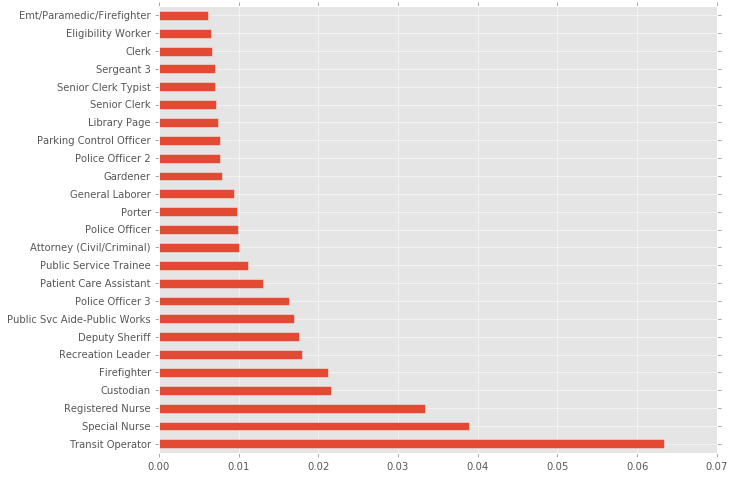

In [169]:
salarydf.JobTitleFormatted.value_counts(normalize=True).head(25).plot(kind='barh',figsize=(10,8))

### It looks like nearly 6.5% of SF workers are working as transit operators, given the efficiency of their public transportation system this isn't all that surprising

# Let's look at salary variance

In [114]:
salaryvardf = salarydf.groupby(by = salarydf.JobTitleFormatted).var()

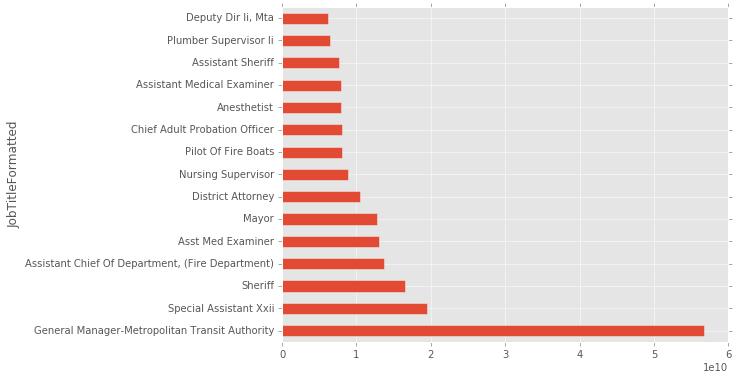

In [115]:
salaryvardf.TotalPay.sort_values(axis=0,ascending=False).head(15).plot(kind='barh',figsize=(8,6))

### The general manager of the transit authority seems to have wildly varying pay

In [68]:
salarydf[salarydf.JobTitleFormatted == 'General Manager-Metropolitan Transit Authority']

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status,JobTitleFormatted
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,,567595.43,567595.43,2011,,San Francisco,,General Manager-Metropolitan Transit Authority
83,84,EDWARD REISKIN,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,230827,0,0,,230827.12,230827.12,2011,,San Francisco,,General Manager-Metropolitan Transit Authority


In [73]:
167411/230827

0.7252661083842011

In [74]:
230827/167411

1.3788042601740627

#### That's a difference of nearly 28%, or 37% depending on who you're looking at

## Let's see who has the most overtime pay

#### First let's fix the missing values

In [191]:
salarydf.OvertimePay[salarydf.OvertimePay == 'Not Provided'] = np.NAN
salarydf.OvertimePay=salarydf.OvertimePay.astype('float')
salarydf.BasePay[(salarydf.BasePay == 'Not Provided') | (salarydf.BasePay == '')] = np.NAN
salarydf.BasePay=salarydf.BasePay.astype('float')

H:\Anaconda2\envs\py3k\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
H:\Anaconda2\envs\py3k\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [192]:
salarymeandf = salarydf.groupby(salarydf.JobTitleFormatted).mean()

In [193]:
salarymeandf.head()

,Id,BasePay,OvertimePay,TotalPay,TotalPayBenefits,Year
JobTitleFormatted,,,,,,
Account Clerk,83122.319088,42593.966897,234.586809,43009.395299,58212.534872,2012.549858
Accountant,24159.200000,46643.172000,0.000000,47429.268000,47429.268000,2011.000000
Accountant I,89791.500000,61777.832500,0.000000,62036.101250,88122.188750,2012.875000
Accountant Ii,93921.393805,66880.084425,8.408673,67355.202699,95086.024027,2013.022124
Accountant Iii,90994.359712,78940.945000,7.197374,79001.071547,107741.412158,2013.039568


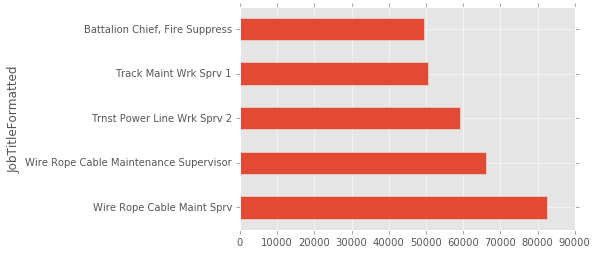

In [194]:
salarymeandf.OvertimePay.sort_values(ascending=False).head().plot(kind='barh')

#### It looks like those working as supervisors in dangerous jobs accrue the largest average overtime

### Let's sort on overtime pay and look at which positions make the most in overtime as a percentage of their base salary

In [199]:
salarymeandf.sort_values('OvertimePay',ascending=False,inplace=True)

In [200]:
salarymeandf.head()

,Id,BasePay,OvertimePay,TotalPay,TotalPayBenefits,Year
JobTitleFormatted,,,,,,
Wire Rope Cable Maint Sprv,74151.666667,92751.746667,82446.923333,203033.720000,242118.323333,2013.000000
Wire Rope Cable Maintenance Supervisor,267.000000,85624.870000,66164.730000,199628.970000,199628.970000,2011.000000
Trnst Power Line Wrk Sprv 2,75060.666667,113870.616667,59259.306667,175467.503333,214776.440000,2013.000000
Track Maint Wrk Sprv 1,77797.478261,77581.106087,50613.903478,136156.472609,168449.382174,2012.913043
"Battalion Chief, Fire Suppress",91816.923077,179084.045238,49453.051385,252546.943231,306954.552769,2013.476923


In [201]:
salarymeandf['OTpercOfSalary']=salarymeandf.OvertimePay/salarymeandf.BasePay

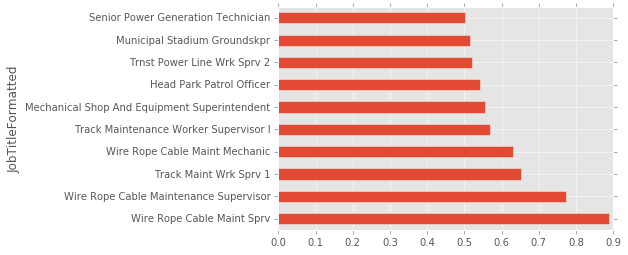

In [205]:
#Ignore recreation director, as it shows up as the max, as it's listed as infinity as base pay is 0
salarymeandf.OTpercOfSalary[salarymeandf.index != 'Recreation Director'].sort_values(ascending=False).head(10).plot(kind='barh')

In [209]:
salarydf[salarydf.JobTitleFormatted == 'Recreation Director']

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status,JobTitleFormatted
30913,30914,HUEY THOMAS,RECREATION DIRECTOR,0.0,225.98,12315.6,,12541.63,12541.63,2011,,San Francisco,,Recreation Director
32097,32098,SCOTT GOLDE,RECREATION DIRECTOR,0.0,0.00,8562.96,,8562.96,8562.96,2011,,San Francisco,,Recreation Director
32545,32546,MICHAEL CHEATHAM,RECREATION DIRECTOR,0.0,67.55,7268.99,,7336.54,7336.54,2011,,San Francisco,,Recreation Director
33565,33566,KEITH BURROUGHS,RECREATION DIRECTOR,0.0,0.00,4314.81,,4314.81,4314.81,2011,,San Francisco,,Recreation Director
34909,34910,DAVETTE MINOR,RECREATION DIRECTOR,0.0,0.00,1762.94,,1762.94,1762.94,2011,,San Francisco,,Recreation Director
34910,34911,JAMES BROWN,RECREATION DIRECTOR,0.0,0.00,1761.97,,1761.97,1761.97,2011,,San Francisco,,Recreation Director
34946,34947,JERI JACKSON,RECREATION DIRECTOR,0.0,0.00,1686.4,,1686.40,1686.40,2011,,San Francisco,,Recreation Director
35059,35060,GWENDOLYN WIGGINS,RECREATION DIRECTOR,0.0,0.00,1475.6,,1475.60,1475.60,2011,,San Francisco,,Recreation Director
35179,35180,EDWARD WONG,RECREATION DIRECTOR,0.0,0.00,1269.12,,1269.12,1269.12,2011,,San Francisco,,Recreation Director
35291,35292,JANELLE PIERCE,RECREATION DIRECTOR,0.0,0.00,1139.17,,1139.17,1139.17,2011,,San Francisco,,Recreation Director


#### It looks like recreation directors are unpaid but for some reason receive overtime and other pay